# Notebook to create Eo-Re-Mo diagramms programmatically

## Overview

The aim of this notebook is to provide a quick way for creating specialized $Eo-Re-Mo$ diagramms (Eötvös-Reynolds-Morton). First, the original iso-Morton lines are imported from a *csv* files. The data was extracted from figure 2.5 on page 27 in *Bubbles, Drops, and Particles* by R. Clift, J. R. Grace, and M. E. Weber using [Digitizer](http://markummitchell.github.io/engauge-digitizer/).

In [1]:
import helper_module as hm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import torch
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

%matplotlib inline

## Load data

The first column contains all *Eo* values. Entries are separated by tabs.

In [2]:
isoMoLines = pd.read_csv("../data/EoReMo/EoMoDiag-MortonCurves.csv", sep="\t")
sphericalBoundary = pd.read_csv("../data/EoReMo/EoMoDiag-SphericalBoundary.csv", sep="\t")

# load some shapes
data_path = "../data/"
names = ["bhaga_02_l16", "bhaga_03_l16", "bhaga_04_l16", "water_05_l16"]
times = [30, 30, 20, 14]
cases = [data_path + name for name in names]
all_facets = {}
for i, case in enumerate(cases):
    log_path = case + "/log." + names[i] + ".csv"
    log = hm.Logfile(log_path)
    log.read_logfile(usecols=['time', 'x'])
    row = log.find_closest("time", times[i])
    plic_path = case + "/plic_clean/plic_{:06d}.pkl".format(row.index.values[0]*10)
    all_facets[names[i]] = hm.FacetCollection2D(plic_path, [0, row.x.values[0]], True)
    
print("")

# Eo values
EoValues = isoMoLines['Eo'].values
print("The last five Eo numbers are {} ({} values in total)".format(EoValues[-5:-1], len(EoValues)))

# Mo values
MoValues = isoMoLines.columns.values.tolist()[1:]
MoValues = [int(Mo) for Mo in MoValues]
print("Log(Mo) ranges from {} to {} ({} values in total).".format(MoValues[-1], MoValues[0], len(MoValues)))

ReValues = isoMoLines.values[:,1:]
print("Shape of the Re value array: {}".format(ReValues.shape))
# first iso Mo line
ReValues[:,0]

Successfully read file ../data/bhaga_02_l16/log.bhaga_02_l16.csv
Successfully read file ../data/bhaga_02_l16/plic_clean/plic_062070.pkl
Successfully read file ../data/bhaga_03_l16/log.bhaga_03_l16.csv
Successfully read file ../data/bhaga_03_l16/plic_clean/plic_089590.pkl
Successfully read file ../data/bhaga_04_l16/log.bhaga_04_l16.csv
Successfully read file ../data/bhaga_04_l16/plic_clean/plic_036380.pkl
Successfully read file ../data/water_05_l16/log.water_05_l16.csv
Successfully read file ../data/water_05_l16/plic_clean/plic_677920.pkl

The last five Eo numbers are [ 630.957  707.946  794.328  891.251] (101 values in total)
Log(Mo) ranges from -12 to 8 (21 values in total).
Shape of the Re value array: (101, 21)


array([  2.37392000e-09,   2.84743000e-09,   3.41539000e-09,
         4.09664000e-09,   4.91378000e-09,   5.89391000e-09,
         7.06954000e-09,   8.47966000e-09,   1.01711000e-08,
         1.21998000e-08,   1.46333000e-08,   1.75521000e-08,
         2.10531000e-08,   2.52525000e-08,   3.02895000e-08,
         3.63312000e-08,   4.35780000e-08,   5.22703000e-08,
         6.26964000e-08,   7.52021000e-08,   9.02023000e-08,
         1.08195000e-07,   1.29776000e-07,   1.55661000e-07,
         1.86710000e-07,   2.23953000e-07,   2.68623000e-07,
         3.22204000e-07,   3.86473000e-07,   4.63561000e-07,
         5.56025000e-07,   6.66932000e-07,   7.99962000e-07,
         9.59526000e-07,   1.15092000e-06,   1.38049000e-06,
         1.65585000e-06,   1.98613000e-06,   2.38229000e-06,
         2.85748000e-06,   3.42744000e-06,   4.11110000e-06,
         4.93112000e-06,   5.91471000e-06,   7.09448000e-06,
         8.50959000e-06,   1.02070000e-05,   1.22429000e-05,
         1.46849000e-05,

## Create ML model and scale data
An MLP model based on the original Eo-Re-Mo diagramm is useful to interpolate between the given Mo-lines.

In [3]:
simpleMLP = hm.SimpleMLP(n_inputs=2, n_outputs=1, n_layers=8, n_neurons=80,
                         activation=torch.nn.functional.relu, batch_norm=False)

file_path = "../output/models/EoReMoModel.pt"

# Scaling
scalerX = MinMaxScaler()
scalerY = MinMaxScaler()

# feature vector
# Eo, Mo
logEo = np.log10(EoValues)
X = scalerX.fit_transform(np.array(np.meshgrid(logEo, MoValues)).T.reshape(-1, 2))

# label vector
# Re
logRe = np.log10(ReValues)
y = scalerY.fit_transform(logRe.flatten().reshape(-1, 1))

print("Shape of the feature vector: {}".format(X.shape))
print("Shape of the feature vector: {}".format(y.shape))

Shape of the feature vector: (2121, 2)
Shape of the feature vector: (2121, 1)


100%|██████████| 5000/5000 [03:08<00:00, 26.53it/s]


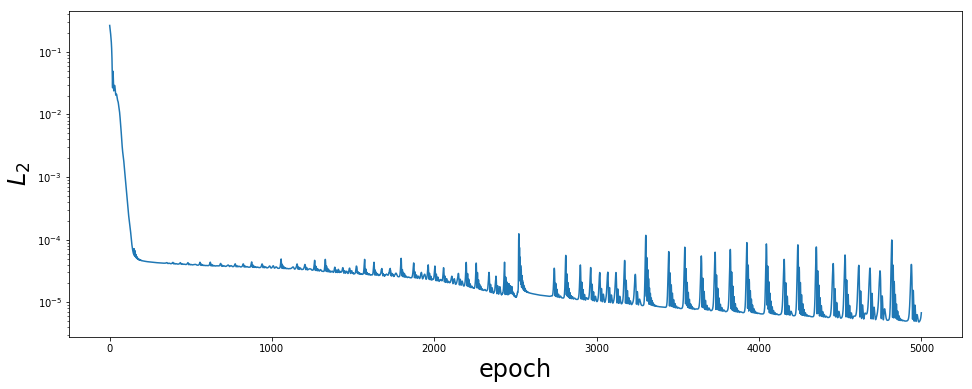

In [4]:
rc('text', usetex=False)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

criterion = torch.nn.SmoothL1Loss()  
optimizer = torch.optim.Adam(simpleMLP.parameters(), lr=0.001)

X_tensor = torch.from_numpy(np.float64(X))
y_tensor = torch.from_numpy(np.float64(y))

min_loss = 1.0E8
losses = []
epochs = 5000

for epoch in tqdm(range(1, epochs+1)):
    optimizer.zero_grad()
    output = simpleMLP.forward(X_tensor)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if loss.item() < min_loss:
        torch.save(simpleMLP.state_dict(), file_path)
        min_loss = loss.item()

ax.plot(range(1, epochs+1), losses)
ax.set_xlabel("epoch", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$L_2$", fontsize=hm.fontsize_label)
ax.set_yscale('log')

In [5]:
def compute_iso_morton_line(logMo, EoVal):
    simpleMLP.load_state_dict(torch.load(file_path))
    logMoArray = np.ones(EoVal.shape[0]) * logMo
    X_scale = scalerX.transform(np.squeeze(np.dstack((np.log10(EoVal), logMoArray))))
    X_scale_tensor = torch.from_numpy(np.float64(X_scale))
    return scalerY.inverse_transform(simpleMLP(X_scale_tensor).detach().numpy())

## Base plot

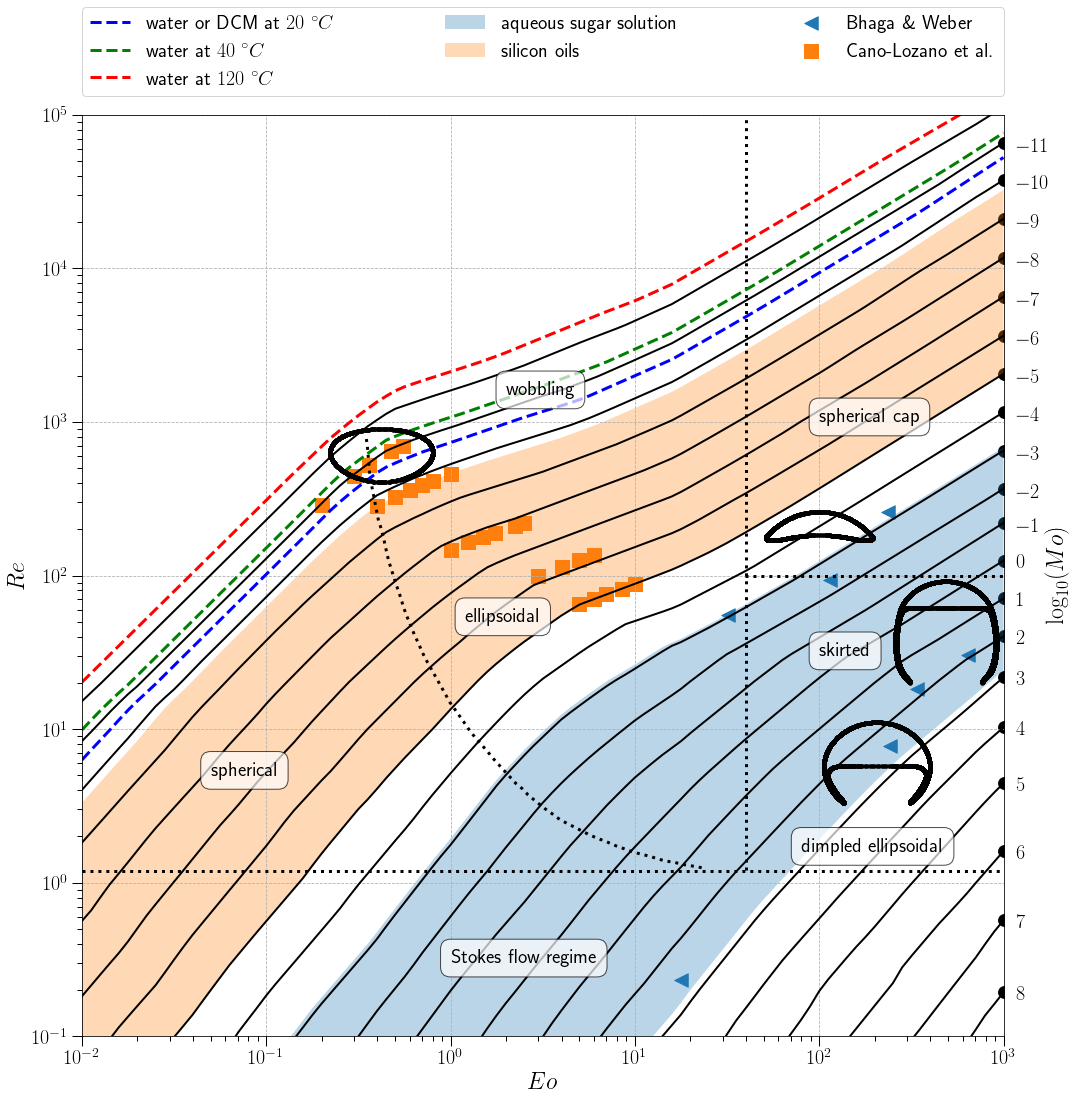

In [6]:
rc('text', usetex=True)
fig = plt.figure(figsize=(hm.figure_width, 16))
ax = fig.add_axes([0.0, 0.0, 0.8, 0.8])

# x axis and label
ax.set_xlim([1.0E-2, 1.0E3])
ax.set_xscale("log")
ax.set_xlabel(r"$Eo$", fontsize=hm.fontsize_label)

# y axis and label
ax.set_ylim([0.1, 1.0E5])
ax.set_yscale("log")
ax.set_ylabel(r"$Re$", fontsize=hm.fontsize_label)

# tick length and width
ax.tick_params(length=10, width=1, which='major', labelsize=hm.fontsize_tick)
ax.tick_params(length=5, width=1, which='minor')

# with grid for major ticks
ax.grid(which='major', linestyle='--')

# Mo label
ax.text(1.05, 0.5, r"$\mathrm{log}_{10}(Mo)$",
        horizontalalignment='left',
        verticalalignment='center',
        rotation=90,
        clip_on=False,
        transform=plt.gca().transAxes,
        fontsize=hm.fontsize_label)

# Stokes flow regime
ax.axhline(1.2, 0.0, 1.0, ls=":", c="k", lw=hm.line_width)

# spherical cap regime
ax.axvline(40, 0.18, 1.0, ls=":", c="k", lw=hm.line_width)
ax.axhline(100, 0.72, 1.0, ls=":", c="k", lw=hm.line_width)

# spherical regime
ax.plot(sphericalBoundary["Eo"].values[:-30], sphericalBoundary["spherical"].values[:-30], c='k', lw=hm.line_width, ls=':')

# iso Mo lines
lastRe = []
for ind, Mo in enumerate(MoValues):
    ReCurr = np.power(10.0, compute_iso_morton_line(Mo, EoValues))
    lastRe.append(ReCurr[-1])
    ax.plot(EoValues, ReCurr, c="k", lw=2)
    # uncomment to show original iso Mo lines
    # ax.plot(EoValues, ReValues[:,ind], c='k')

# Mo ticks
for ind, Mo in enumerate(MoValues[:-1]): 
    plt.scatter(EoValues[-1], lastRe[ind], c="k", s=140)
    ax.text(1.175*EoValues[-1], 0.9*lastRe[ind], r"${}$".format(Mo), fontsize=hm.fontsize_tick)
    # uncomment to show original iso Mo values
    # plt.scatter(EoValues[-1], ReValues[-1,ind], c='k', s=140)
    # ax.text(1.175*EoValues[-1], 0.9*ReValues[-1,ind], r"${}$".format(Mo), fontsize=hm.fontsize_tick)
    
# Mo test lines 
logMoWater20 = np.log10(2.5728E-11)
Re20 = np.power(10.0, compute_iso_morton_line(logMoWater20, EoValues))
ax.plot(EoValues, Re20, c='b', ls='--', lw=hm.line_width, label=r"water or DCM at $20~^\circ C$")

logMoWater40 = np.log10(5.3059E-12)
Re40 = np.power(10.0, compute_iso_morton_line(logMoWater40, EoValues))
ax.plot(EoValues, Re40, c='g', ls='--', lw=hm.line_width, label=r"water at $40~^\circ C$")

logMoWater120 = np.log10(3.11417E-13)
Re120 = np.power(10.0, compute_iso_morton_line(logMoWater120, EoValues))
ax.plot(EoValues, Re120, c='r', ls='--', lw=hm.line_width, label=r"water at $120~^\circ C$")

# Mo values by Bhaga and Weber
logMoBhaga = np.log10(np.asarray([8.2E-4, 711.0]))
ReBhaga = [np.squeeze(np.power(10.0, compute_iso_morton_line(logMoI, EoValues))) for logMoI in logMoBhaga]
ax.fill_between(EoValues, ReBhaga[0], ReBhaga[1], facecolor='C0', alpha=0.3, label="aqueous sugar solution" )

# Mo values for silicon oils, Cano-Lozano et al. 2016
logMoCano = np.log10(np.asarray([1.8E-10, 9.9E-6]))
ReCano = [np.squeeze(np.power(10.0, compute_iso_morton_line(logMoI, EoValues))) for logMoI in logMoCano]
ax.fill_between(EoValues, ReCano[1], ReCano[0], facecolor='C1', alpha=0.3, label="silicon oils" )

# Simulations by Cano-Lozano and experiments by Bhaga and Weber
eo_exp_bhaga = [8.67, 17.7, 32.2, 243, 115, 237, 339, 641]
re_exp_bhaga = [0.078, 0.232, 55.3, 7.77, 94.0, 259, 18.3, 30.3]
ax.scatter(eo_exp_bhaga, re_exp_bhaga, marker="<", s=180, c="C0", label=r"Bhaga \& Weber")

mo_sim_cano = np.asarray([1.11E-11, 1.8E-10, 1.6E-8, 6.2E-7, 9.9E-6])
eo_sim_cano = np.asarray([
    [0.2, 0.3, 0.36, 0.475, 0.55],
    [0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
    [1.0, 1.25, 1.5, 1.75, 2.25, 2.5],
    [3.0, 4.0, 5.0, 6.0],
    [5.0, 6.0, 7.0, 8.5, 10.0]
])
re_sim_cano = [np.squeeze(np.power(10.0, compute_iso_morton_line(np.log10(mo), np.asarray(eo)))) for mo, eo in zip(mo_sim_cano, eo_sim_cano)]
for eo, re in zip(eo_sim_cano[:-1], re_sim_cano[:-1]):
    ax.scatter(eo, re, s=180, c="C1", marker="s")
ax.scatter(eo_sim_cano[-1], re_sim_cano[-1], s=180, c="C1", marker="s", label=r"Cano-Lozano et al.")

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0., fontsize=hm.fontsize_legend)

# add some information text boxes
bbox = dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5')
ax.text(1.0, 0.3, "Stokes flow regime", fontsize=hm.fontsize_legend, bbox=bbox)
ax.text(0.05, 5, "spherical", fontsize=hm.fontsize_legend, bbox=bbox)
ax.text(100, 1000, "spherical cap", fontsize=hm.fontsize_legend, bbox=bbox)
ax.text(1.2, 50, "ellipsoidal", fontsize=hm.fontsize_legend, bbox=bbox)
ax.text(2, 1500, "wobbling", fontsize=hm.fontsize_legend, bbox=bbox)
ax.text(100, 30, "skirted", fontsize=hm.fontsize_legend, bbox=bbox)
ax.text(80, 1.6, "dimpled ellipsoidal", fontsize=hm.fontsize_legend, bbox=bbox)

# add some shapes
ax_bhaga_02 = plt.axes([0.64, 0.19, 0.1, 0.1], xticks=[], yticks=[], xlim=[-0.7, 0.7], ylim=[-0.65, 0.5])
ax_bhaga_03 = plt.axes([0.59, 0.39, 0.1, 0.1], xticks=[], yticks=[], xlim=[-0.9, 0.9], ylim=[-0.5, 0.5])
ax_bhaga_04 = plt.axes([0.7, 0.3, 0.1, 0.1], xticks=[], yticks=[], xlim=[-0.9, 0.9], ylim=[-1.2, 0.5])
ax_water = plt.axes([0.21, 0.45, 0.1, 0.1], xticks=[], yticks=[], xlim=[-0.7, 0.7], ylim=[-0.65, 0.5])

for name, subax in zip(names, [ax_bhaga_02, ax_bhaga_03, ax_bhaga_04, ax_water]):
    x, y =  all_facets[name].get_facets()
    subax.scatter(x, y, c="k", s=10)
    subax.scatter(-x, y, c="k", s=10)
    subax.patch.set_facecolor("white")
    subax.axis('off')
    subax.set_aspect('equal')

# save plot as pdf
plt.savefig('../output/EoReMo.pdf', bbox_inches='tight')
plt.savefig('../output/EoReMo.png', bbox_inches='tight')

In [9]:
# compute Re for a 3 mm air bubble in water at 120°C
Eo_120 = 1.515
Re_120 = np.squeeze(np.power(10.0, compute_iso_morton_line(logMoWater120, np.asarray([Eo_120, Eo_120]))))
print(Re_120)

[ 2501.34724463  2501.34724463]
